# Pytorch LSTM

## 라이브러리 호출 및 데이터 확인

In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
import sys
import platform
print(sys.version)
print(platform.system())

3.10.9 | packaged by Anaconda, Inc. | (main, Mar  1 2023, 18:18:15) [MSC v.1916 64 bit (AMD64)]
Windows


In [3]:
# 통합 seed 고정함수 생성
import random

# GPU를 사용하지 않지만 학습을 위해 cuda 세팅도 함께 진행

def seed_all(seed):
    print(f'Using Seed Number {seed}')
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed) # CPU상 Pytorch 시드 고정
    torch.cuda.manual_seed(seed) # GPU상 Pytorch 시드 고정
    torch.cuda.manual_seed_all(seed)# 멀티 GPU상 Pytorch 시드 고정
    np.random.seed(seed) # NumPy 시드 고정
    random.seed(seed) # random모듈 시드 고정

# cuDNN(cuda Deep Neural network Library)
# 딥 러닝 및 인공 신경망(ANN) 프레임워크를 가속화하기 위한 라이브러리
# cuDNN은 딥 뉴럴 네트워크를 위한 GPU 가속화 라이브러리의 기초 요소

    torch.backends.cudnn.deterministic = True
    # 결과가 재현 가능, 성능에 영향
    torch.backends.cudnn.benchmark = False
    # 최적화 기능 (True인 경우 빠르지만 결과 재현성이 떨어짐)
    torch.backends.cudnn.enabled = False
    # 고정된 결과를 얻기위해 False (속도는 느려진다.)


def seed_worker(_worker_id):
    worker_seed = torch.initial_seed() % 2**32
    # 시드를 32비트로 제한, 호환성 확보, 동일한 결과를 다른환경에서 재현.
    np.random.seed(worker_seed)
    random.seed(worker_seed)

seed_all(seed = 42)


Using Seed Number 42


In [4]:
# 데이터 로드
rawdata = pd.read_excel('data/분석데이터_new.xlsx', engine='openpyxl')
rawdata.head()

,년/월,시도,산업_대분류,구인인원,취업건수,사업체 수,실업급여 수급자 수,각 지역별 인구,GDP(실질),금리,CLI 지수,소비자 심리지수
0,201301,서울,제조업,60,0,30219,97,10195064,1562.7,2.75,99.14964,101.0
1,201301,서울,도매 및 소매업,104,0,109382,202,10195064,1562.7,2.75,99.14964,101.0
2,201301,서울,정보통신업,763,4,23384,1230,10195064,1562.7,2.75,99.14964,101.0
3,201301,서울,"전문, 과학 및 기술 서비스업",35,1,33649,70,10195064,1562.7,2.75,99.14964,101.0
4,201301,서울,"사업시설 관리, 사업 지원 및 임대 서비스업",64,0,11578,62,10195064,1562.7,2.75,99.14964,101.0


In [5]:
# 컬럼명 맞추기
rawdata.columns=['date', 'city', 'industry', 'job_offer', 'employment',
              'no_company', 'unemployment', 'population', 'GDP', 'i_rate', 'CLI', 'CFI']

# date 컬럼 날짜 데이터로 변경
rawdata['date'] = pd.to_datetime(rawdata['date'], format='%Y%m')

# rawdata.head()


# int 형식을 float 형식으로 변경
rawdata['job_offer'] = rawdata['job_offer'].astype(float)
rawdata['employment'] = rawdata['employment'].astype(float)
rawdata['no_company'] = rawdata['no_company'].astype(float)
rawdata['unemployment'] = rawdata['unemployment'].astype(float)
rawdata['population'] = rawdata['population'].astype(float)

In [6]:
rawdata.head()

,date,city,industry,job_offer,employment,no_company,unemployment,population,GDP,i_rate,CLI,CFI
0,2013-01-01,서울,제조업,60.0,0.0,30219.0,97.0,10195064.0,1562.7,2.75,99.14964,101.0
1,2013-01-01,서울,도매 및 소매업,104.0,0.0,109382.0,202.0,10195064.0,1562.7,2.75,99.14964,101.0
2,2013-01-01,서울,정보통신업,763.0,4.0,23384.0,1230.0,10195064.0,1562.7,2.75,99.14964,101.0
3,2013-01-01,서울,"전문, 과학 및 기술 서비스업",35.0,1.0,33649.0,70.0,10195064.0,1562.7,2.75,99.14964,101.0
4,2013-01-01,서울,"사업시설 관리, 사업 지원 및 임대 서비스업",64.0,0.0,11578.0,62.0,10195064.0,1562.7,2.75,99.14964,101.0


In [7]:
rawdata.describe()

,job_offer,employment,no_company,unemployment,population,GDP,i_rate,CLI,CFI
count,10200.000000,10200.000000,10200.000000,10200.000000,1.020000e+04,10200.000000,10200.000000,10200.000000,10200.000000
mean,18.614412,0.611863,11486.520980,50.862745,3.034329e+06,1769.280000,1.570833,100.220536,100.690000
std,62.382935,2.171046,22390.025086,171.907800,3.204186e+06,126.255275,0.665539,1.024875,7.064863
min,0.000000,0.000000,25.000000,0.000000,1.139110e+05,1562.700000,0.500000,98.577410,73.300000
25%,1.000000,0.000000,1397.500000,3.000000,1.476969e+06,1658.000000,1.250000,99.513373,97.975000
50%,4.000000,0.000000,3200.500000,9.000000,1.893935e+06,1786.400000,1.500000,100.201950,101.800000
75%,14.000000,0.000000,12721.500000,29.000000,2.953138e+06,1852.700000,2.000000,100.800350,105.000000
max,926.000000,39.000000,142545.000000,1855.000000,1.359006e+07,1968.800000,3.250000,102.888300,112.000000


- 데이터 정상성 확인

In [10]:
# Augmented Dickey Fuller Test : 평균, 분산이 시간에 따라 일정(정상성)해야 함을 검증

from statsmodels.tsa.stattools import adfuller

def ad_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print('1. statistic:', dftest[0])
    print('2. p-value:', dftest[1])
    print('3. number of lags', dftest[2])
    print('4. Number of observation Used for ADF Regression and critical values calculations:', dftest[3])
    print('5. Critical Values:', dftest[4])
    for key, val in dftest[4].items():
        print(key, ':', val, end='\n')

In [11]:
raw_ex = rawdata[(rawdata['city'] == '서울') & (rawdata['industry'] == '정보통신업')]
log_ex = log_data[(log_data['city'] == '서울') & (log_data['industry'] == '정보통신업')]

In [12]:
ad_test(raw_ex['job_offer'])

1. statistic: -3.1282995463946364
2. p-value: 0.024528554205774884
3. number of lags 1
4. Number of observation Used for ADF Regression and critical values calculations: 118
5. Critical Values: {'1%': -3.4870216863700767, '5%': -2.8863625166643136, '10%': -2.580009026141913}
1% : -3.4870216863700767
5% : -2.8863625166643136
10% : -2.580009026141913


In [13]:
ad_test(log_ex['job_offer'])

1. statistic: -3.25321961971264
2. p-value: 0.017103524221389506
3. number of lags 1
4. Number of observation Used for ADF Regression and critical values calculations: 118
5. Critical Values: {'1%': -3.4870216863700767, '5%': -2.8863625166643136, '10%': -2.580009026141913}
1% : -3.4870216863700767
5% : -2.8863625166643136
10% : -2.580009026141913


## LSTM모델 생성

- 데이터 스케일링

In [14]:
# object 컬럼 : One-Hot encoding
object_columns = ['city', 'industry']

oe = OneHotEncoder(sparse = False, drop = 'first') # drop first를 통해 컬럼 축소
raw_oe = oe.fit_transform(rawdata[object_columns])

# 원핫인코딩 된 컬럼명 
column_name = [col for col in oe.categories_[0][1:]] + [col for col in oe.categories_[1][1:]]
# 원핫 인코딩 데이터프레임 생성
raw_cat_df = pd.DataFrame(raw_oe, columns = column_name)
# 원본 데이터와 원핫 인코딩 concat
rawdata = pd.concat([rawdata, raw_cat_df], axis = 1)
# 기존 object컬럼 drop
rawdata = rawdata.drop(columns = object_columns)
rawdata.head()

c:\Users\yju12\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,date,job_offer,employment,no_company,unemployment,population,GDP,i_rate,CLI,CFI,...,인천,전남,전북,제주,충남,충북,"사업시설 관리, 사업 지원 및 임대 서비스업","전문, 과학 및 기술 서비스업",정보통신업,제조업
0,2013-01-01,60.0,0.0,30219.0,97.0,10195064.0,1562.7,2.75,99.14964,101.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2013-01-01,104.0,0.0,109382.0,202.0,10195064.0,1562.7,2.75,99.14964,101.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2013-01-01,763.0,4.0,23384.0,1230.0,10195064.0,1562.7,2.75,99.14964,101.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2013-01-01,35.0,1.0,33649.0,70.0,10195064.0,1562.7,2.75,99.14964,101.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2013-01-01,64.0,0.0,11578.0,62.0,10195064.0,1562.7,2.75,99.14964,101.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [15]:
# 독립, 종속변수 분리 후 trian, test 분리

rawdata.set_index('date', inplace = True) # 날짜컬럼 인덱스 변환

y = rawdata[['job_offer']] 
x = rawdata.drop('job_offer', axis = 1)

train1_x, test1_x,  train1_y, test1_y = train_test_split(x, y, test_size = 0.2, shuffle = False)
print(train1_x.shape, train1_y.shape, test1_x.shape, test1_y.shape)


(8160, 28) (8160, 1) (2040, 28) (2040, 1)


---

In [16]:
# 데이터 스케일링
scale_columns = ['employment', 'no_company', 'unemployment', 'population', 'GDP', 'i_rate', 'CLI', 'CFI']
train_scale = train1_x[scale_columns]
test_scale = test1_x[scale_columns]

M_scaler = MinMaxScaler()
S_scaler = StandardScaler()

# 종속변수 : MinMax / 독립변수 : Standard 사용
train1_y = M_scaler.fit_transform(train1_y)
test1_y = M_scaler.transform(test1_y)

train1_x[scale_columns] = S_scaler.fit_transform(train_scale)
test1_x[scale_columns] = S_scaler.transform(test_scale)


In [18]:
# 텐서 변환
train1_x_tensors = torch.Tensor(train1_x.values)
test1_x_tensors = torch.Tensor(test1_x.values)

train1_y_tensors = torch.Tensor(train1_y)
test1_y_tensors = torch.Tensor(test1_y)

train1_x_tensors.shape, test1_x_tensors.shape

(torch.Size([8160, 28]), torch.Size([2040, 28]))

In [19]:
train1_x_tensors_f = torch.reshape(train1_x_tensors, (8160, 1, 28))
test1_x_tensors_f = torch.reshape(test1_x_tensors, (2040, 1, 28))

print(train1_x_tensors_f.shape, test1_y_tensors.shape, test1_x_tensors_f.shape, test1_y_tensors.shape)

torch.Size([8160, 1, 28]) torch.Size([2040, 1]) torch.Size([2040, 1, 28]) torch.Size([2040, 1])


- LSTM 모델 생성

In [20]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes  # 클래스 개수
        self.num_layers = num_layers    # LSTM 계층의 개수
        self.input_size = input_size    # 입력 크기
        self.hidden_size = hidden_size  # 은닉층의 뉴런 개수
        self.seq_length = seq_length    # 시퀀스 길이
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)    # LSTM 계층
        self.fc_1 = nn.Linear(hidden_size, 128) # 완전 연결층
        self.fc = nn.Linear(128, num_classes)   # 출력층
        self.relu = nn.ReLU()
    
    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) # 은닉 상태를 0으로 초기화
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size) # 셀 상테를 0으로 초기화
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # LSTM 계층에 은닉 상태와 셀 상태 적용
        hn = hn.view(-1, self.hidden_size)  # 완전연결층 적용을 위해 데이터의 형태 조정
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [21]:
# 모델 학습을 위한 변수 값 설정
num_epochs = 1000       # 에포크 횟수 지정
learning_rate = 0.0001  # 학습률 지정

input_size = 28 # 입력 데이터셋의 컬럼 개수
hidden_size = 2 # 은닉층의 뉴런/유닛 개수
num_layers = 1  # LSTM 계층의 개수

num_classes = 1 # 클래스 개수
model = LSTM(num_classes, input_size, hidden_size, num_layers, train1_x_tensors_f.shape[1])

criterion = torch.nn.MSELoss() #loss함수 정의
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # 최적화 함수에 가중치 전달

![가중치와 loss 기울기](https://wikidocs.net/images/page/21670/%EC%A0%91%EC%84%A0%EC%9D%98%EA%B8%B0%EC%9A%B8%EA%B8%B01.PNG)

In [22]:
# 모델 학습
for epoch in range(num_epochs):
    outputs = model.forward(train1_x_tensors_f) # 전방향(forward) 학습
    optimizer.zero_grad() # 기울기를 0으로 초기화
    # 기울기를 0으로 초기화하지 않는경우 미분값이 계속 누적됨.
    loss = criterion(outputs, train1_y_tensors) # 손실 함수를 이용한 오차 계산(모델 학습 결과와 레이블의 차이 계산)
    loss.backward() # 기울기 계산 (가중치, loss와의 기울기)
    
    optimizer.step() # 가중치, 편향 업데이트
    if epoch % 100 == 0:    # 1000을 100으로 나누어 나머지가 0이면 출력
        print(f'Epoch: {epoch}, loss: {loss.item()}')

Epoch: 0, loss: 0.18665726482868195
Epoch: 100, loss: 0.048580851405858994
Epoch: 200, loss: 0.009568249806761742
Epoch: 300, loss: 0.003173795295879245
Epoch: 400, loss: 0.002417833311483264
Epoch: 500, loss: 0.0021445793099701405
Epoch: 600, loss: 0.0019166995771229267
Epoch: 700, loss: 0.0017278133891522884
Epoch: 800, loss: 0.0015851319767534733
Epoch: 900, loss: 0.001481349696405232


## 모델 예측결과 출력

In [23]:
rawdata.iloc[:, 1:9]

,employment,no_company,unemployment,population,GDP,i_rate,CLI,CFI
date,,,,,,,,
2013-01-01,0.0,30219.0,97.0,10195064.0,1562.7,2.75,99.14964,101.0
2013-01-01,0.0,109382.0,202.0,10195064.0,1562.7,2.75,99.14964,101.0
2013-01-01,4.0,23384.0,1230.0,10195064.0,1562.7,2.75,99.14964,101.0
2013-01-01,1.0,33649.0,70.0,10195064.0,1562.7,2.75,99.14964,101.0
2013-01-01,0.0,11578.0,62.0,10195064.0,1562.7,2.75,99.14964,101.0
...,...,...,...,...,...,...,...,...
2022-12-01,0.0,2134.0,2.0,678159.0,1968.8,3.25,98.75089,90.2
2022-12-01,0.0,7385.0,6.0,678159.0,1968.8,3.25,98.75089,90.2
2022-12-01,0.0,559.0,23.0,678159.0,1968.8,3.25,98.75089,90.2


In [24]:
rawdata.iloc[:, 1:9] = S_scaler.transform(rawdata.iloc[:, 1:9])
rawdata['job_offer'] = M_scaler.transform(rawdata[['job_offer']])

In [26]:
rawdata_scale_x = rawdata.drop('job_offer', axis=1)
rawdata_scale_y = rawdata[['job_offer']]

rawdata_scale_x = Variable(torch.Tensor(rawdata_scale_x.values))
rawdata_scale_y = Variable(torch.Tensor(rawdata_scale_y.values))

rawdata_scale_x = torch.reshape(rawdata_scale_x, (rawdata_scale_x.shape[0], 1, rawdata_scale_x.shape[1]))

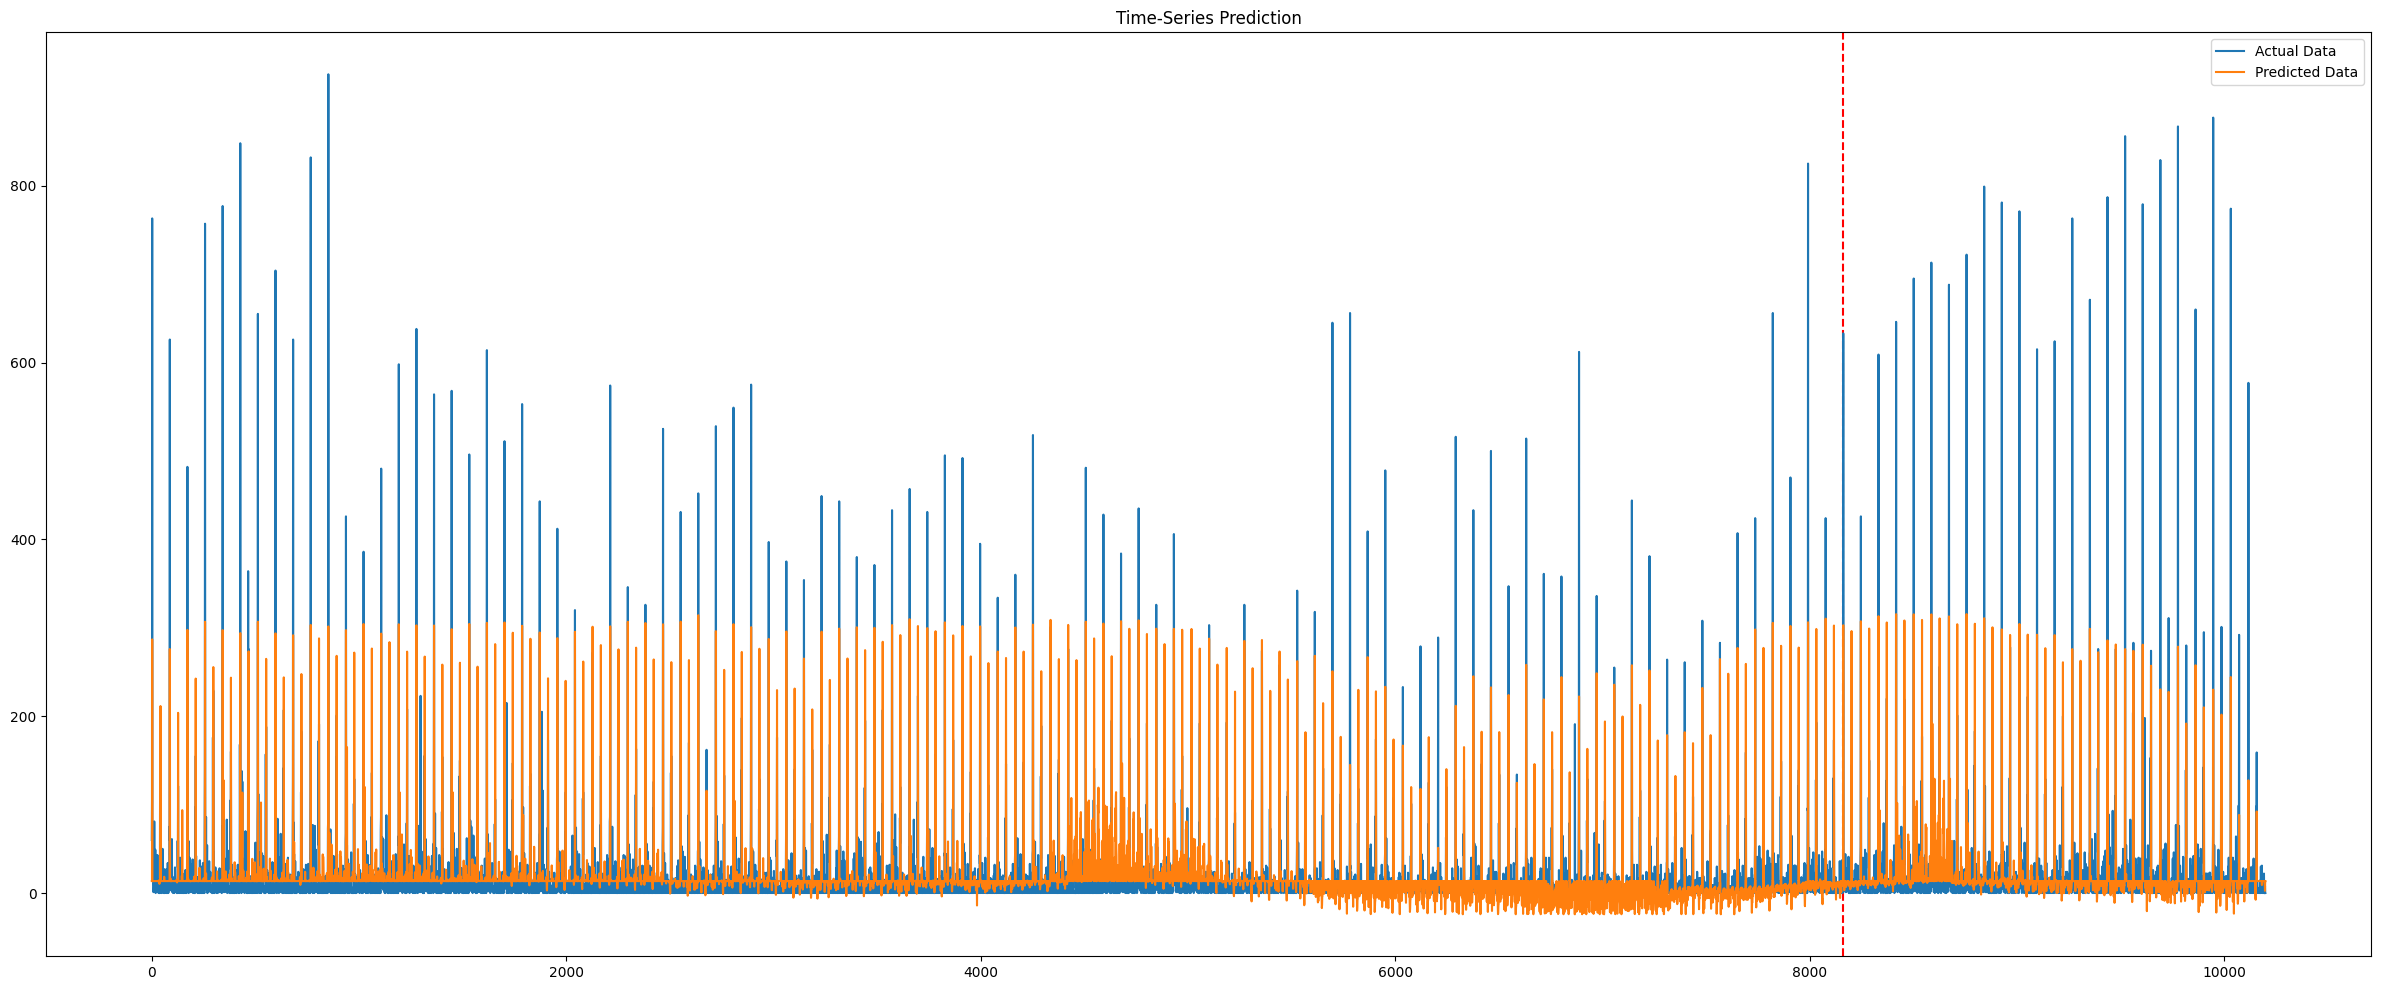

In [29]:
train_predict = model(rawdata_scale_x)
predicted = train_predict.data.numpy()
label_y = rawdata_scale_y.data.numpy()

# M_scaler.inverse를 통해 스케일 값을 다시 원상복귀
predicted = M_scaler.inverse_transform(predicted)
label_y = M_scaler.inverse_transform(label_y)

plt.figure(figsize=(30, 12))
plt.axvline(x=8160, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

In [31]:
with torch.no_grad():
    preds = []
    model.eval()
    predict = model(test1_x_tensors_f)

predicted = predict.data.numpy()
predicted = M_scaler.inverse_transform(predicted)
real_value = rawdata.iloc[8160:, :].reset_index(drop=True)['job_offer']
pred_df = pd.DataFrame({'real':real_value, 'pred':predicted.reshape(-1)})
pred_df

,real,pred
0,0.037797,13.525466
1,0.036717,13.525466
2,0.683585,302.873657
3,0.036717,13.525466
4,0.024838,13.525466
...,...,...
2035,0.000000,10.518620
2036,0.000000,8.543606
2037,0.008639,2.500325
2038,0.001080,13.525466


In [32]:
# validataion score
# score의 경우 실제값과 예측값의 차이가 작을수록 100에 가까워지는 점수
MSE = mean_squared_error(pred_df['real'], pred_df['pred'])
RMSE = np.sqrt(MSE)
# MSLE = mean_squared_log_error(pred_df['real'], pred_df['pred'])   # nagative 값으로 인해 출력 불가
# RMSLE = np.sqrt(MSLE)
score = 100 * (1 - (((pred_df['pred'] - pred_df['real']) ** 2).sum())/((pred_df['real'] ** 2).sum()))
corr = pred_df.corr().iloc[0, 1]
print(f'MSE: {MSE}, RMSE: {RMSE}, score: {score}, corr: {corr}')

MSE: 2108.494788715958, RMSE: 45.9183491505951, score: -24509866.38113337, corr: 0.8097062348219208


## 양방향 LSTM

In [36]:
class biLSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(biLSTM, self).__init__()
        self.num_classes = num_classes  # 클래스 개수
        self.num_layers = num_layers    # LSTM 계층의 개수
        self.input_size = input_size    # 입력 크기
        self.hidden_size = hidden_size  # 은닉층의 뉴런 개수
        self.seq_length = seq_length    # 시퀀스 길이
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, bidirectional=True, batch_first=True)    # LSTM 계층
        self.fc = nn.Linear(hidden_size*2, 128) # 완전 연결층
        self.relu = nn.ReLU()
    
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size))   # 은닉 상태를 0으로 초기화
        c_0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size))   # 셀 상테를 0으로 초기화
        out, _ = self.lstm(x, (h_0, c_0)) # LSTM 계층에 은닉 상태와 셀 상태 적용
        out = self.fc(out[:, -1, :])    # 마지막 시간(time step상 마지막 단계)의 은닉 상태
        out = self.relu(out)
        return out

In [37]:
# 모델 학습을 위한 변수 값 설정
num_epochs = 1000       # 에포크 횟수 지정
learning_rate = 0.0001  # 학습률 지정

input_size = 28 # 입력 데이터셋의 컬럼 개수
hidden_size = 2 # 은닉층의 뉴런/유닛 개수
num_layers = 1  # LSTM 계층의 개수

num_classes = 1 # 클래스 개수
model = biLSTM(num_classes, input_size, hidden_size, num_layers, train1_x_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [38]:
# 모델 학습
for epoch in range(num_epochs):
    outputs = model.forward(train1_x_tensors_f) # 전방향(forward) 학습
    optimizer.zero_grad()
    loss = criterion(outputs, train1_y_tensors) # 손실 함수를 이용한 오차 계산(모델 학습 결과와 레이블의 차이 계산)
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:    # 1000을 100으로 나누어 나머지가 0이면 출력
        print(f'Epoch: {epoch}, loss: {loss.item()}')

c:\Users\yju12\anaconda3\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([8160, 1])) that is different to the input size (torch.Size([8160, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, loss: 0.04725247621536255
Epoch: 100, loss: 0.04351193830370903
Epoch: 200, loss: 0.040085531771183014
Epoch: 300, loss: 0.036881573498249054
Epoch: 400, loss: 0.033847857266664505
Epoch: 500, loss: 0.030959390103816986
Epoch: 600, loss: 0.028202109038829803
Epoch: 700, loss: 0.025570543482899666
Epoch: 800, loss: 0.023066066205501556
Epoch: 900, loss: 0.020703056827187538


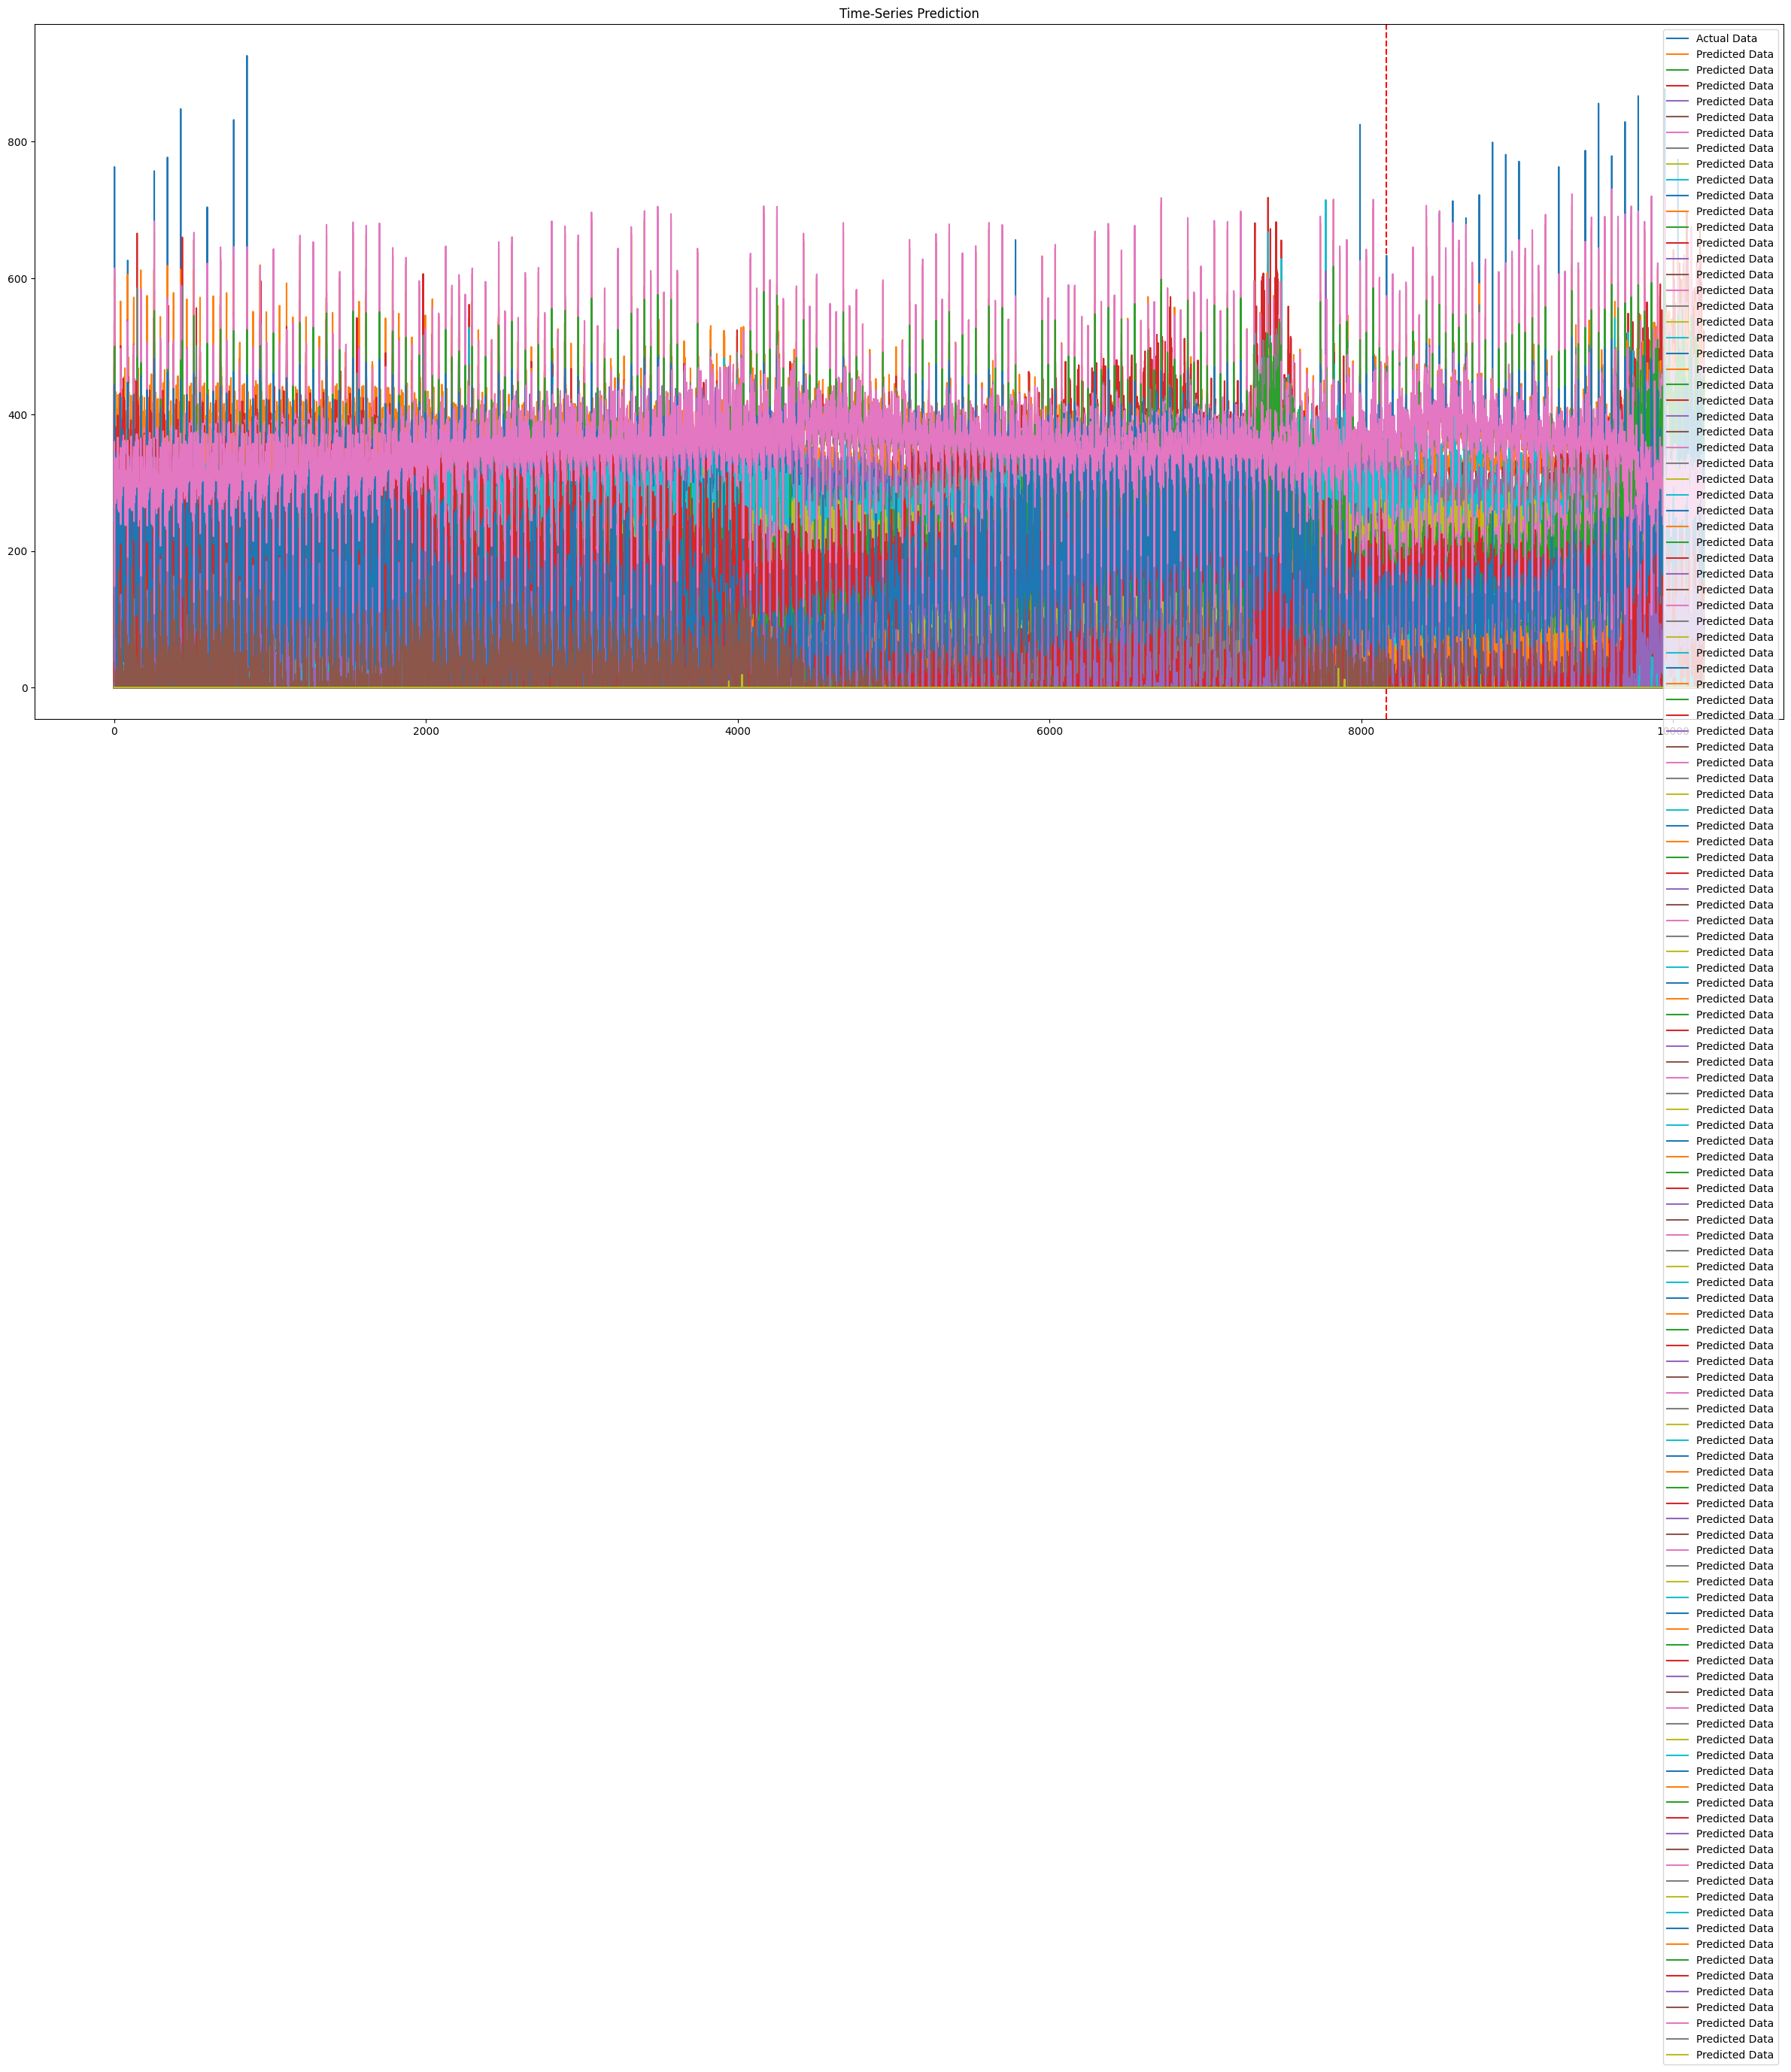

In [40]:
train_predict = model(rawdata_scale_x)
predicted = train_predict.data.numpy()
label_y = rawdata_scale_y.data.numpy()

predicted = M_scaler.inverse_transform(predicted)
label_y = M_scaler.inverse_transform(label_y)
plt.figure(figsize=(30, 12))
plt.axvline(x=8160, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

## LSTM (log적용)

In [43]:
# train, test set 분리
train_data4 = log_data.iloc[:8160, :].reset_index(drop=True)
test_data4 = log_data.iloc[8160:, :].reset_index(drop=True)
print(train_data4.shape, test_data4.shape)

(8160, 12) (2040, 12)
